In [2]:
# buckling inputs
# ----------------

import numpy as np
from scipy.optimize import fsolve

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
# D = 1

# choose loading type (first just uniaxial loading in x-direction)
# axial = True
axial = False
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# a, b = (1, 1)
(a, b) = (3, 1)

# predict the buckling load factor (BLF)
pi = 3.14159
if axial:
    pred_buckling_load = pi**2 * D / b**2 * 4.0 
    pred_load_factor = pred_buckling_load / Nxx
    sigma = 0.5 * pred_load_factor
    print(f"{pred_load_factor=}")
else: # shear case
    def resid(_s2):
        s1_sq = np.sqrt(1.0 + 2.0 * _s2**2 + _s2**4)
        return s1_sq + _s2**2 + 1.0/3.0 - np.sqrt(4.0/9.0 + 4.0/3.0 * s1_sq + 4.0/3.0 * s1_sq**2)

    s2_soln = fsolve(resid, x0=1.0)
    print(f"{s2_soln=}")
    s2 = s2_soln[0]
    s1_sq = np.sqrt(1.0 + 2.0 * s2**2 + s2**4)
    s2_resid = resid(s2)
    print(f"{s2_resid=}")

    # sean's closed-form soln for shear
    pred_buckling_load_star = (1.0 + s1_sq**2 + 6 * s1_sq * s2**2 + s2**4 + 2.0 * (s1_sq + s2**2)) / 2.0 / (s1_sq * s2**2)
    rho = a / b
    ar_factor = np.max([1.0, 1.0/rho**2])
    pred_buckling_load = pi**2 * D / b**2 * pred_buckling_load_star * ar_factor
    
    # from chatgpt pred_buckling_load for shear, simply supported (first estimate)
    # pred_buckling_load = 4 * E / 2.0 / (1 + nu) / thick**2 / (1 - nu**2)
    pred_load_factor = pred_buckling_load / Nxy
    sigma = 0.9 * pred_load_factor
    # sigma = 0.1
    print(f"{pred_load_factor=}")
    # sigma = 50.0

s2_soln=array([0.70710678])
s2_resid=0.0
pred_load_factor=632.6658800064105


2024-12-04 21:07:02.021563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733364422.056549   82973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733364422.066434   82973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 21:07:02.146916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


W0000 00:00:1733364424.078686   82973 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


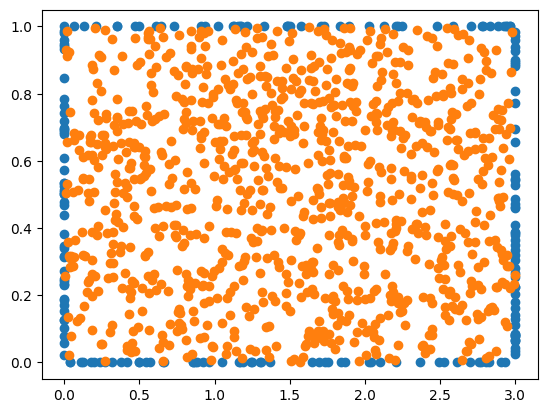

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

num_domain = 10000
num_test = 500

DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
N_b = 100
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:1000,0], x_train[:1000,1]) # only show 1000 of the points
plt.show()

In [33]:
# from tensorflow.keras.initializers import HeNormal

# now start building the tensorflow model
n_inputs = 2
n_outputs = 1
hidden_units = [100]*3
# hidden_units = [40]*3
activation = 'tanh'
# activation = 'relu'

# define custom function for automatically satisfying the BCs
def bc_function(xy):
    x, y = xy[:, 0], xy[:, 1]  # Assuming xy is a batch of [x, y]
    return x * (a - x) * y * (b - y) / a / b

def my_lambda_func(inputs):
    phi, xy = inputs
    g = tf.expand_dims(bc_function(xy), -1)  # Compute g(x, y)
    return phi * g  # Multiply phi by g(x, y)

# have to use functional API for defining the model here
# previous example uses model.add but since we have BC function here, we have to use functional API

model = tf.keras.models.Sequential()

input_layer = tf.keras.layers.Input((n_inputs,))

null_init = None
he_init = tf.keras.initializers.HeNormal() # not great because results in large init BC loss
glorot_init = tf.keras.initializers.GlorotUniform()
zero_init = tf.keras.initializers.Zeros()
lecun_init = tf.keras.initializers.LecunUniform(
    seed=None
)
# glorot init and other simple initializers result in it getting stuck near the 1-half wave mode a lot
random_init = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.05, seed=None
)
random_init2 = tf.keras.initializers.RandomUniform(
    minval=-0.05, maxval=0.05, seed=None
)
random_init3 = tf.keras.initializers.RandomUniform(minval=-10.0, maxval=10.0)
random_init4 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=10.0)
random_init5 = tf.keras.initializers.RandomNormal(mean=-0.5, stddev=0.1)

hidden = input_layer
for units in hidden_units:
  hidden = tf.keras.layers.Dense(units=units, activation=activation, kernel_initializer='he_normal', bias_initializer=random_init5)(hidden)
  # debug : add dropout layers?
#   model.add(tf.keras.layers.Dropout(0.2))

# last_activation = 'tanh' # for normalized output since eigenmode
last_activation = None 
outer_hidden = tf.keras.layers.Dense(units=n_outputs, activation=last_activation, kernel_initializer='he_normal', bias_initializer=random_init5)(hidden)

# add auto BC layer, makes always simply supported
# Extract x and y from inputs
# x = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z[:, 0], axis=-1), name="extract_x")(input_coords)  # Extract x with shape (None, 1)
# y = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z[:, 1], axis=-1), name="extract_y")(input_coords)  # Extract y with shape (None, 1)

bc_layer = tf.keras.layers.Lambda(my_lambda_func)([outer_hidden, input_layer])
model = tf.keras.Model(inputs=input_layer, outputs=bc_layer)

model.build(input_shape=(None,2))

model.summary()

# also add lambda the eigenvalue trainable parameter to update
guess = pred_load_factor # cheat guess first
lambda_var = model.add_weight(name="lambda_var", initializer=tf.keras.initializers.Constant(guess), trainable=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100)       │        300 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 100)       │     10,100 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 100)       │     10,100 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │        101 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ dense_15[0][0],   │
│                     │                   │            │ input_layer_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,601 (80.47 KB)

 Trainable params: 20,601 (80.47 KB)

 Non-trainable params: 0 (0.00 B)

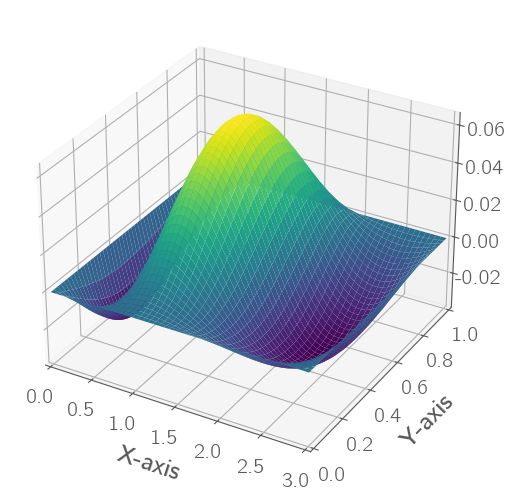

In [34]:
# plot the initial buckling mode prediction
import matplotlib.pyplot as plt
import numpy as np

def plot_mode(n=50):
    n = 50
    x_vec = np.linspace(0, a, n)
    y_vec = np.linspace(0, b, n)
    X, Y = np.meshgrid(x_vec, y_vec)
    x_flat = np.reshape(X, newshape=(n*n,1))
    y_flat = np.reshape(Y, newshape=(n*n,1))
    grid_inputs = np.concatenate([x_flat, y_flat], axis=1)
    w = model(grid_inputs)
    W = np.reshape(w, newshape=(n,n))

    # plt.figure(figsize=(8, 6))
    # colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    # plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, W, cmap='viridis')

    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    # plt.title("2D Contour Plot")
    plt.show()

plot_mode()

In [35]:
# fit and optimize the model
# epochs = 10000
# epochs = 1000
epochs = 100
# epochs = 10

import time
losses_hist = []

learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=epochs,
#     decay_rate=0.01,
#     staircase=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# print(f"{type(x_train)=}")
best_weights = model.get_weights()
best_loss = 1e8

for i in range(epochs + 1):
  start_time = time.time()

  with tf.GradientTape(persistent=False) as tape_model:

    # pde loss
    with tf.GradientTape(persistent=True) as tape3:
      tape3.watch(x)
      tape3.watch(y)
      with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)  # Ensure that x is watched by tape1
        tape2.watch(y)  # Ensure that y is watched by tape1
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)  # Ensure that x is watched by tape1
            tape1.watch(y)  # Ensure that y is watched by tape1
            w_raw = model(tf.stack([x[:, 0], y[:, 0]], axis=1), training=True)
            # normalize the eigenmode so it focuses on shape of eigenmode instead of just trying to make the
            # magnitudes smaller..
            w = w_raw / tf.norm(w_raw)
            # print(f"{w=}")
            
            # Compute gradients with respect to x and y
            dx = tape1.gradient(w, x)
            dy = tape1.gradient(w, y)
            # print(f"{dx=} {dy=}")

        # Compute the second derivative of dx with respect to x
        d2x = tape1.gradient(dx, x)
        dxy = tape1.gradient(dx, y)
        d2y = tape1.gradient(dy, y)
        # print(f"{d2x=} {dxy=} {d2y=}")

      d3x = tape2.gradient(d2x, x)
      d2xy = tape2.gradient(d2x, y)
      d3y = tape2.gradient(d2y, y)
      # print(f"{d3x=}")

    d4x = tape3.gradient(d3x, x)
    d2x2y = tape3.gradient(d2xy, y)
    d4y = tape3.gradient(d3y, y)
    # print(f"{d4x=} {d2x2y=} {d4y=}")

    # now compute PDE residual
    # consider normalizing PDE residual a bit.. so more comparable to BC loss
    # divide by eigenvalue so can't be zero (useful to do this)
    # even in shear this will avoid repeated flipped Nxy eigenvalues (so ok)
    res_pde = (d4x + 2. * d2x2y + d4y) / lambda_var - \
            (Nxx * d2x + 2. * Nxy * dxy + Nyy * d2y) / D
    res_pde *= 3000.0    
    # print(f"{res_pde=}")


    # compute mse loss function
    pde_mse = tf.math.reduce_mean(tf.math.square(res_pde), axis=0)
    total_mse = pde_mse 

    # debug try just bndry loss
    # total_mse = bndry_mse

  # compute training gradients (ML model and lambd teh eigenvalue)
  # grads_lambda = tape_model.gradient(total_mse, lambd)
  model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
  # print(f"{grads_lambda=}")
  # bndry_gradients = tape_model.gradient(bndry_mse, model.trainable_variables)
  # print(f"{model_update_gradients=}")
  # print(f"{bndry_gradients=}")
  # exit(0)

  del tape1, tape2, tape3

  # apply optimizer updates to ML model and predicted eigenvalue
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )  
  # optimizer.apply_gradients([(grads_lambda, lambd)])

  del tape_model

  # validation loss
  with tf.GradientTape(persistent=True) as tape3:
    tape3.watch(x2)
    tape3.watch(y2)
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch(x2)  # Ensure that x is watched by tape1
      tape2.watch(y2)  # Ensure that y is watched by tape1
      with tf.GradientTape(persistent=True) as tape1:
          tape1.watch(x2)  # Ensure that x is watched by tape1
          tape1.watch(y2)  # Ensure that y is watched by tape1
          w_raw = model(tf.stack([x2[:, 0], y2[:, 0]], axis=1), training=True)
          # normalize the eigenmode so it focuses on shape of eigenmode instead of just trying to make the
          # magnitudes smaller..
          w = w_raw / tf.norm(w_raw)
          # print(f"{w=}")
          
          # Compute gradients with respect to x and y
          dx = tape1.gradient(w, x2)
          dy = tape1.gradient(w, y2)
          # print(f"{dx=} {dy=}")

      # Compute the second derivative of dx with respect to x
      d2x = tape1.gradient(dx, x2)
      dxy = tape1.gradient(dx, y2)
      d2y = tape1.gradient(dy, y2)
      # print(f"{d2x=} {dxy=} {d2y=}")

    d3x = tape2.gradient(d2x, x2)
    d2xy = tape2.gradient(d2x, y2)
    d3y = tape2.gradient(d2y, y2)
    # print(f"{d3x=}")

  d4x = tape3.gradient(d3x, x2)
  d2x2y = tape3.gradient(d2xy, y2)
  d4y = tape3.gradient(d3y, y2)
  # print(f"{d4x=} {d2x2y=} {d4y=}")

  # now compute PDE residual
  # consider normalizing PDE residual a bit.. so more comparable to BC loss
  # divide by eigenvalue so can't be zero (useful to do this)
  # even in shear this will avoid repeated flipped Nxy eigenvalues (so ok)
  res_pde = (d4x + 2. * d2x2y + d4y) / lambda_var - \
          (Nxx * d2x + 2. * Nxy * dxy + Nyy * d2y) / D
  res_pde *= 30.0    
  # print(f"{res_pde=}")
  del tape1, tape2, tape3


  # compute mse loss function
  val_loss = tf.math.reduce_mean(tf.math.square(res_pde), axis=0).numpy()[0]

  train_loss = total_mse.numpy()[0]
  eigval = lambda_var.numpy()
  pde_loss = pde_mse.numpy()[0]
  bndry_loss = 0.0
  # val_loss = tf.math.reduce_mean(model(x_test))
  # val_loss = 0.0
  dt = time.time() - start_time
  print(f"Epoch: {i}\t{train_loss=}\t{val_loss=}\t{bndry_loss=}\t{eigval=}\t{dt=}")

  if train_loss < best_loss:
    best_loss = train_loss
    best_weights = model.get_weights()

  losses_hist += [
    {'train' : train_loss, 'val' : val_loss}
  ]

  if abs(train_loss) < 0.01: # error based stopping criterion
    break

  if i % 1000 == 0:
    # y_preds = model(x_test)
    test_mse = tf.constant(-1)
    # test_mse = tf.math.reduce_mean(tf.math.square(y_preds - tf.math.sin(np.pi*x_test)), axis=0)
    print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, total_mse.numpy()[0], test_mse.numpy()))

# set best weights back in
model.set_weights(best_weights)

Epoch: 0	train_loss=5731.3823	val_loss=8.7521925	bndry_loss=0.0	eigval=632.6664	dt=2.695134162902832
Epoch: 0	Train Loss = 5731.38232421875,	Test Loss = -1
Epoch: 1	train_loss=4482.982	val_loss=5.295984	bndry_loss=0.0	eigval=632.6668	dt=2.676835775375366
Epoch: 2	train_loss=2650.494	val_loss=4.1004653	bndry_loss=0.0	eigval=632.6673	dt=2.6615347862243652
Epoch: 3	train_loss=2019.6519	val_loss=3.5582974	bndry_loss=0.0	eigval=632.6677	dt=2.648286819458008
Epoch: 4	train_loss=1750.7772	val_loss=3.2601314	bndry_loss=0.0	eigval=632.66815	dt=2.6542809009552
Epoch: 5	train_loss=1612.7382	val_loss=3.0736914	bndry_loss=0.0	eigval=632.6686	dt=2.6860132217407227
Epoch: 6	train_loss=1531.901	val_loss=2.946255	bndry_loss=0.0	eigval=632.669	dt=2.627065658569336
Epoch: 7	train_loss=1479.7675	val_loss=2.8533385	bndry_loss=0.0	eigval=632.66943	dt=2.7793052196502686
Epoch: 8	train_loss=1443.5507	val_loss=2.7822065	bndry_loss=0.0	eigval=632.66986	dt=2.6743128299713135
Epoch: 9	train_loss=1416.8392	val_los

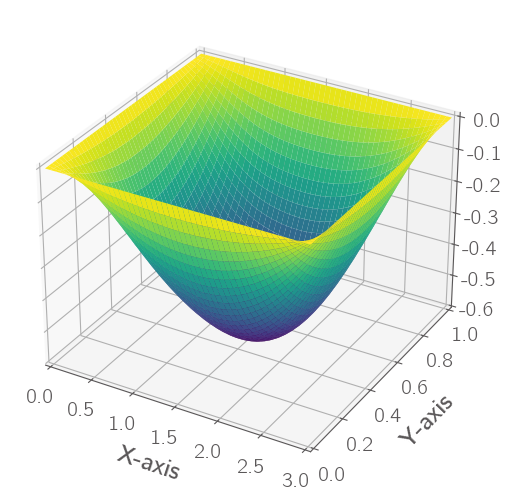

In [36]:
# plot buckling mode again
plot_mode()

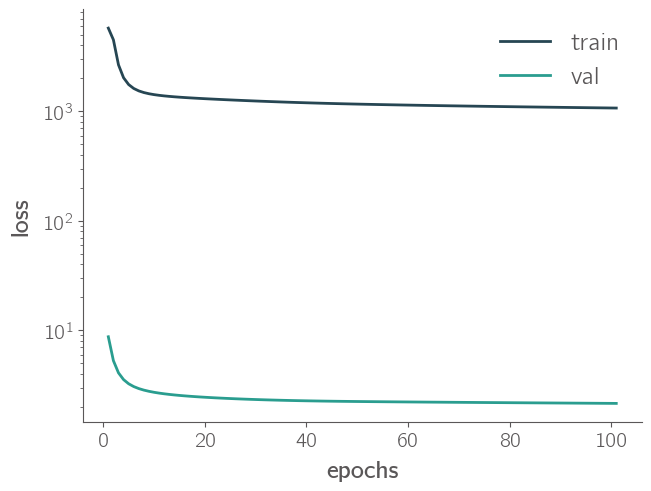

In [37]:
# plot the training losses
import matplotlib.pyplot as plt
import numpy as np
import niceplots
import ml_buckling as mlb

plt.style.use(niceplots.get_style())
ncolors = 3
# colors = plt.cm.jet(np.linspace(0.0, 1.0, ncolors))
colors = mlb.four_colors4
num_epochs = len(losses_hist)
epochs = [_ for _ in range(1, num_epochs + 1)]
# losses_hist += [
#     {'pde' : pde_loss, 'bndry' : bndry_loss, 'train' : train_loss}]
i = 0
for key in ['train', 'val']:
    loss = [_[key] for _ in losses_hist]
    plt.plot(epochs, loss, label=key, color=colors[i])
    i+= 1
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.margins(x=0.05, y=0.05)
plt.legend()

rel_err=1.8209707


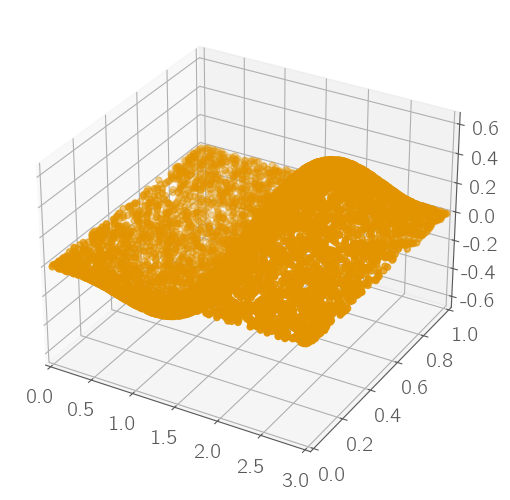

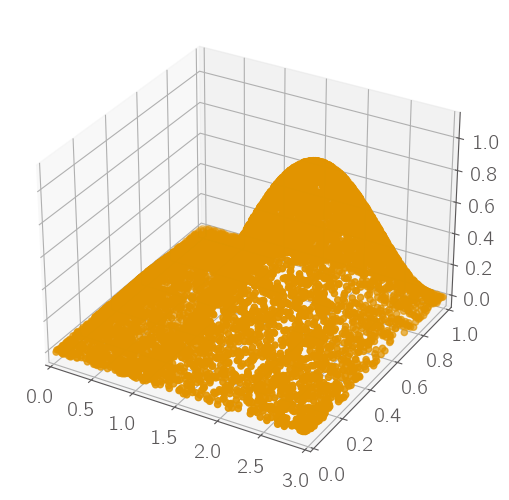

In [38]:
# compute L2 norm of the solution
w_pred = model(x_train)
w_true = -1.0 * np.sin(2.0/3.0 * np.pi * x) * np.sin(np.pi * y) * np.max(np.abs(w_pred))
rel_err = np.max(np.abs(w_true - w_pred)) / np.max(np.abs(w_true))
print(f"{rel_err=}")

# print(f"{w_true=}")
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, w_true)
plt.show()


# plot the error
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, np.abs(w_true - w_pred))
plt.show()


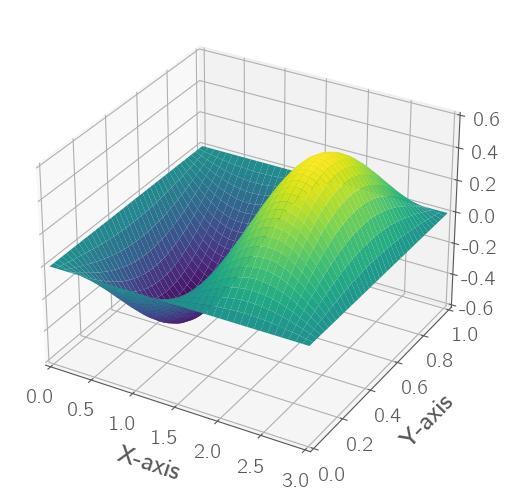

In [39]:
# compute true solution
import matplotlib.pyplot as plt
import numpy as np
n = 40
x_grid = np.linspace(0.0, a, n)
y_grid = np.linspace(0.0, b, n)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
W_true = -1.0 * np.sin(2.0/3.0 * np.pi * X_grid) * np.sin(np.pi * Y_grid) * np.max(np.abs(w_pred))

# plot the true solution
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


surface = ax.plot_surface(X_grid, Y_grid, W_true, cmap='viridis')

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
# plt.title("2D Contour Plot")
plt.show()
